---
title: "GitHub Gists for GIS in Python: Loading a Zipped Local or Web-based Shapefile with One Function" 
author:
  twitter: linwoodc3
summary: This post introduces a utility function that can automatically read web-based or local shapefiles in zip format into the Python ecosystem.  It takes one line of code!
excerpt: "In the world of data science, we embrace the concept of spatial awareness and knowing where the data are (or datum is). In the same way that geospatial grounding (i.e. georeferenced data) brings clarity to a lost traveler, spatial context can bring clarity to a data set.  Moreover, this “where” does not always have to apply to a location on the earth’s surface . Spatial context (i.e. analytic geometry), or understanding data in the context of geometric space, is just as enlightening."
---

## GitHub Gists for GIS in Python: Loading a Zipped Local or Web-based Shapefile with One Function 
**Date:** {{ page.date | date_to_rfc822 }}<br><br>

There is nothing worse than not knowing where you are.

We have all experienced it.  It’s the panic that overtakes you when you don’t recognize your surroundings.  The buildings and roads are unfamiliar.  You don’t know where you are.  Naturally, you focus on getting to a familiar landmark or location.  Reaching that landmark brings a sense of relief.   Comfort.  Peace.  Because you know where you are on a map, it’s easier to plot a course to your final destination.

In the world of data science, we embrace the concept of spatial awareness and knowing where the data are (or datum is). In the same way that  familiar surroundings (i. e. [geo-referenced data](https://en.wikipedia.org/wiki/Georeferencing)) brings clarity to a lost traveler, spatial context can bring clarity to a data set.  This “where” does not always have to apply to a location on the earth’s surface. Spatial context (i.e. [analytic geometry](https://en.wikipedia.org/wiki/Analytic_geometry)), or understanding data in geometric space, is just as enlightening.

[Ansecombe’s quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is a great example. Despite having nearly same summary statistics, the plots are nowhere near same.  This is a reminder to plot your data before drawing a conclusion.  It can prevent costly errors. 

Python's `seaborn` library includes this data set, and we load it and compute the summary statistics.  Each row is a data set, and it's clear that the numbers are nearly identical.

In [1]:
import seaborn as sns

df = sns.load_dataset('anscombe')
ddf = df.groupby('dataset').describe().unstack()
All = slice(None)
test = ddf.T.loc[(All,slice('mean','std')),All]
test

dataset         I        II       III        IV
x mean   9.000000  9.000000  9.000000  9.000000
  std    3.316625  3.316625  3.316625  3.316625
y mean   7.500909  7.500909  7.500000  7.500909
  std    2.031568  2.031657  2.030424  2.030579

dataset         I        II       III        IV
x mean   9.000000  9.000000  9.000000  9.000000
  std    3.316625  3.316625  3.316625  3.316625
y mean   7.500909  7.500909  7.500000  7.500909
  std    2.031568  2.031657  2.030424  2.030579

In [90]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset('anscombe')
ddf = pd.concat([df.groupby('dataset').std(),df.groupby('dataset').mean()],axis=1)
print(ddf)

                x         y    x         y
dataset                                   
I        3.316625  2.031568  9.0  7.500909
II       3.316625  2.031657  9.0  7.500909
III      3.316625  2.030424  9.0  7.500000
IV       3.316625  2.030579  9.0  7.500909


In [16]:
import pytablewriter
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(d)
writer.write_table()
# print(tabulate.tabulate(ddf))

ImportError: No module named 'pytablewriter'

In [74]:
import geopandas as gpd
import numpy as np
import requests
import gdal
import fiona
import uuid  
import re

# informaed by: https://gis.stackexchange.com/questions/225586/reading-raw-data-into-geopandas/225627

def shapefilereader(target):
    """Function to convert zipped shapefiles from the web or on disk into geopandas dataframes
    
    Parameters
    ----------
    target : str
        string representing path to file on disk or url to download the zipped shapefile.
    
    Returns
    -------
    Geopandas dataframe
        Pandas dataframe with geospatial features and operations.
    
    """
    
    # Detect whether we are using a web-based shapefile or local disk
    r = re.compile('^(http|https)://',re.I)
    if r.search(target):
        download = True
        request = requests.get(target)
        target = '/vsimem/{}.zip'.format(uuid.uuid4().hex) #gdal/ogr requires a .zip extension
        gdal.FileFromMemBuffer(target,bytes(request.content))
    else:
        download = False
    
    
    with fiona.Collection(target,vsi='zip') as f:
        return gpd.GeoDataFrame.from_features(f,crs=f.crs)
    
def shaper(row):
    """
    Parallel function to create shapely points
    from latitude/longitude pair in dataframe
    
    Parameters
    ----------
    row : pandas or dask dataframe row
        Row containing latitude and longitude variables and data
    
    Returns
    -------
    shapely point
        Shapely spatial object for geoprocessing in Python.
    """
    geometry=Point(row['longitude'],row['latitude'])
    return geometry

In [4]:
import dask.dataframe as dd
gpd.pd.read_hdf()
ds = dd.read_hdf('/Users/linwood/projects/Blogs/drafts/geolocated_social_transcends_political_barriers/data/tweetLanguages.h5','tweets')

In [102]:
d = (ds[(ds.latitude >=40) & (ds.latitude <=45) & (ds.longitude >=-80) & (ds.longitude<=-70)]).compute()
d.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18076 entries, 2016-07-30 07:16:23 to 2017-04-10 17:00:36
Data columns (total 4 columns):
lang         18076 non-null object
latitude     18076 non-null float64
longitude    18076 non-null float64
type         18076 non-null object
dtypes: float64(2), object(2)
memory usage: 2.5 MB


In [46]:
ny = shapefilereader('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
ny= ny.to_crs({'init':"epsg:4326"})

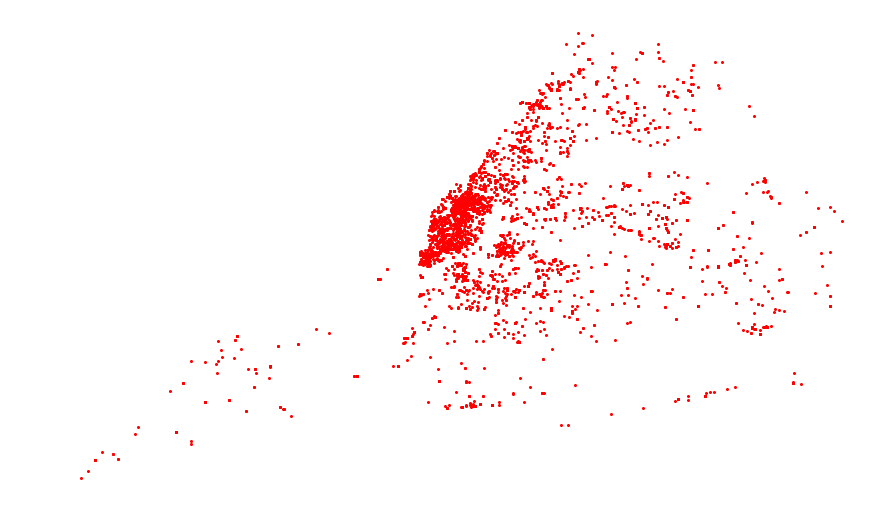

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
nytweets.plot(color='red',ax=ax)
ax.set_axis_off()
plt.savefig('./assets/img/newyorktweets.png')

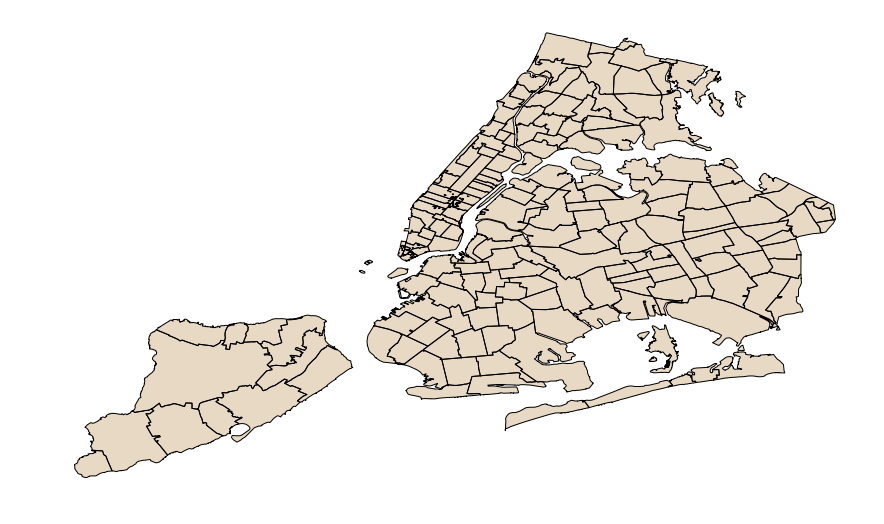

In [170]:
f,ax = plt.subplots(figsize=(15,9))
ax.set_facecolor('lightblue')
ny.plot(color='tan',ax=ax)
ax.set_axis_off()
plt.savefig('./assets/img/newyorkzips.png')
# d.plot(kind='scatter',x='longitude',y='latitude',ax=ax)

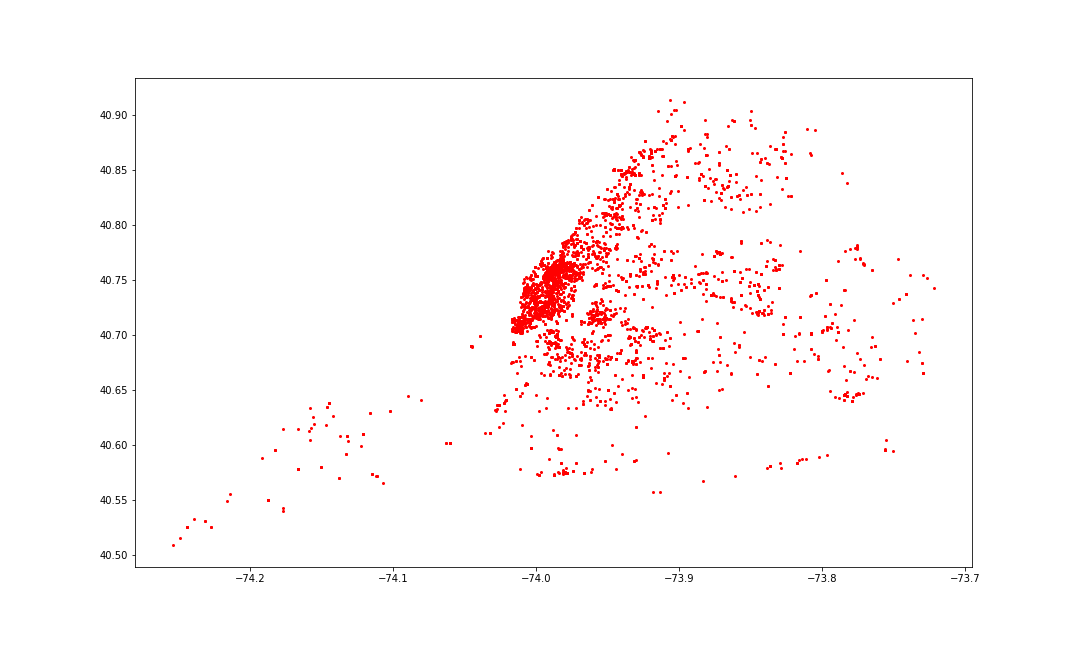

In [134]:
from IPython.display import Image
Image('./assets/img/newyorktweets.png')

In [94]:
from shapely.geometry import Point
dg = gpd.GeoDataFrame(d.assign(geometry=d.apply(shaper,axis=1)),crs = {'init': 'epsg:4326'})

In [96]:
nytweets = gpd.sjoin(dg.reset_index(),ny[['ZIPCODE','geometry','CTY_FIPS']],op='intersects',how='inner')

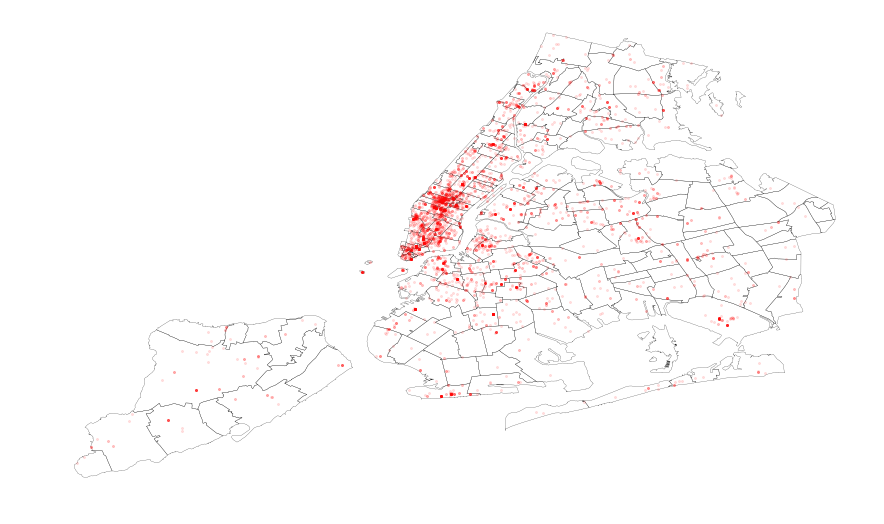

In [171]:
f,ax=plt.subplots(frameon=False,figsize=(15,9))
ny.plot(color='white',linewidth=0.2,ax=ax)
nytweets.plot(color='red',ax=ax,alpha=0.1)
ax.set_axis_off()
plt.savefig('./assets/img/newyorkspatialjoin.png')

In [155]:
import pytablewriter
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(test)
writer.write_table()

ZIPCODE|tweet count
------:|----------:
  10007|        684
  10036|        303
  10001|        257
  10013|        199
     83|        132
  10003|        131
  10019|        130
  11201|        122
  10014|        120
  10011|         99


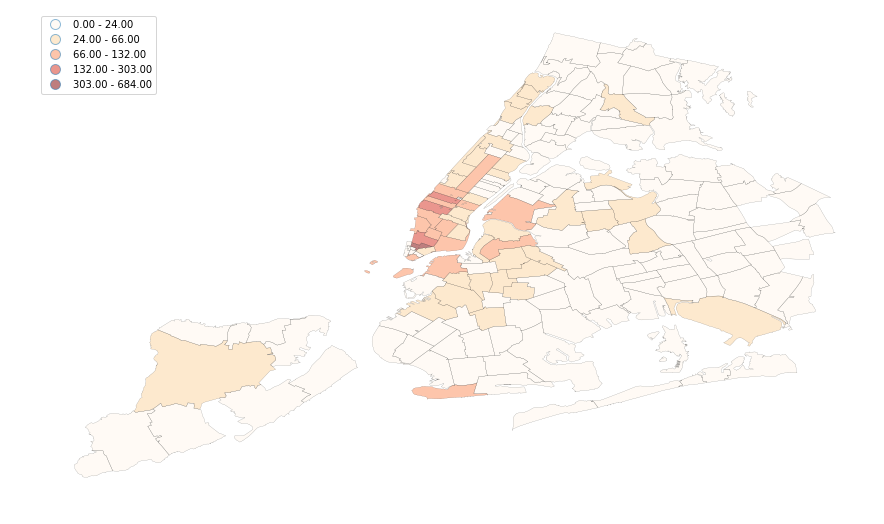

In [176]:
countedTweets = nytweets.groupby('ZIPCODE')['ZIPCODE']\
.size().sort_values(ascending=False)\
.reset_index().rename(columns={0:'tweetcount'})


final = ny[['ZIPCODE','geometry']].merge(countedTweets,on='ZIPCODE')

f,ax = plt.subplots(figsize=(15,9))
final.plot(column='tweetcount', scheme='Fisher_Jenks', k=5, cmap='OrRd', linewidth=0.1, ax=ax,legend=True)
ax.set_axis_off()
plt.savefig('./assets/img/newyorkchoropleth.png')